# Gamma Ray Burst (GRB)

Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research here!). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import sklearn
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from astropy.stats import freedman_bin_width
from sklearn.cluster import MeanShift
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from astropy.visualization.hist import hist as fancyhist
from sklearn.mixture import GaussianMixture
from sklearn.cluster import estimate_bandwidth
import corner
from sklearn.metrics import confusion_matrix
from numpy.random import random
from scipy.stats import rv_histogram

In [2]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

print(names)

['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']


In [12]:
GRB_name=np.array(data[0],dtype=str)
GRB_name_fermi=np.array(data[1],dtype=str)
T0=np.array(data[2],dtype=str)
#t_trigger=np.array(data[3],dtype=float)
ra=np.array(data[3],dtype=float)
dec=np.array(data[4],dtype=float)
pos_err=np.array(data[5],dtype=float)
T90=np.array(data[6],dtype=float)
T_90_err=np.array(data[7],dtype=float)
T_90_start=np.array(data[8],dtype=str)
fluence=np.array(data[9],dtype=float)
fluence_error=np.array(data[10],dtype=float)
redshift=np.array(data[11],dtype=float)
T100=np.array(data[12],dtype=float)
GBM_locaed=np.array(data[13],dtype=str)
mjd=np.array(data[14],dtype=float)
#variable_source=np.array(data[15],dtype=float)



Filled the data arrays I neglct missing data (=-999). And I try some histogram to observe bimodality. Redshift histogram seems a good candidate


7049
587


(0.0, 1000.0)

<Figure size 432x288 with 0 Axes>

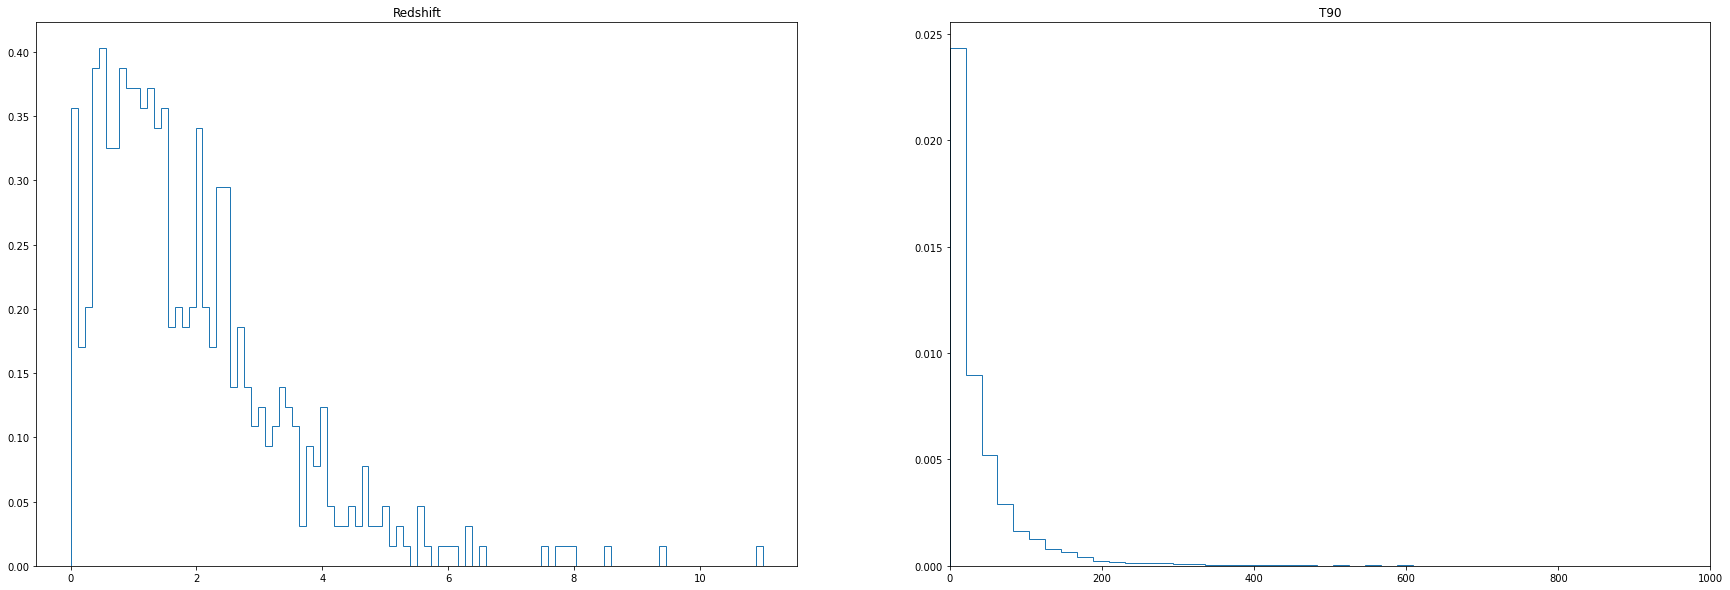

In [13]:
plt.figure()
T90=T90[T90>=0]
z=redshift[redshift>=0]

print(len(T90))
print(len(z))
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.hist(z,bins=100,density=True, histtype='step')
plt.title('Redshift')

plt.subplot(1,2,2)
plt.hist(T90,bins=100,density=True, histtype='step')
plt.title('T90')
plt.xlim(0,1000)

KDE on redshift data



[0.01       0.04413793 0.07827586 0.11241379 0.14655172 0.18068966
 0.21482759 0.24896552 0.28310345 0.31724138 0.35137931 0.38551724
 0.41965517 0.4537931  0.48793103 0.52206897 0.5562069  0.59034483
 0.62448276 0.65862069 0.69275862 0.72689655 0.76103448 0.79517241
 0.82931034 0.86344828 0.89758621 0.93172414 0.96586207 1.        ]


Text(0.5, 1.0, 'redshift KDE')

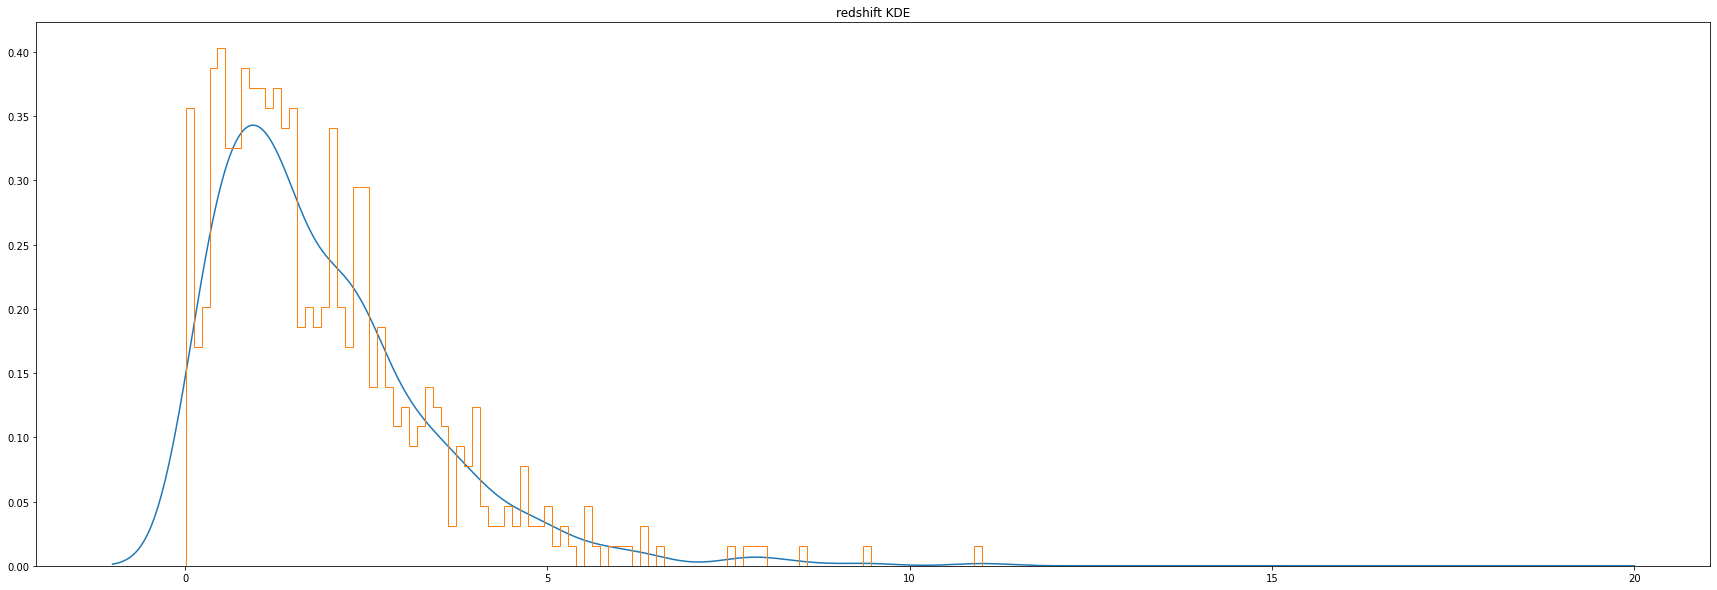

In [5]:
def kde_sklearn(data, bandwidth):
    kde_skl = KernelDensity(bandwidth = bandwidth)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)
    return np.exp(log_pdf)


bwrange = np.linspace(0.01,1.0, 30) # Test 30 bandwidths from 0.1 to 1.0
print(bwrange)
K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K) # Try each bandwidth with K-folds
grid.fit(z[:, None]) #Fit the histogram data that we started the lecture with.
h_opt = grid.best_params_['bandwidth']
#print(h_opt)

xgrid =np.linspace(-1,20,8057)
pdf = kde_sklearn(z,bandwidth=h_opt)

plt.figure(figsize=(30,10))
plt.plot(xgrid,pdf)
plt.hist(z,bins=100,density=True, histtype='step')
plt.title('redshift KDE')


Now I use two clustering methods to determine the centers. I obtain the same results.

In [6]:
X=z.reshape(-1,1)
clf = KMeans(n_clusters=2) #Try 2 clusters to start with
clf.fit(X)

centroid = clf.cluster_centers_
centers=centroid.squeeze()
print(centers)

#let me try another algorithm
bandwidth = sklearn.cluster.estimate_bandwidth(X)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False) 
ms.fit(X)

centroid_ms = clf.cluster_centers_
centers_ms =centroid_ms.squeeze()
print(centers_ms)



/Users/federicoastori/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1.20379364 3.94704218]
[1.20379364 3.94704218]


I also predict the label of the 2 classes in order to count how many short and long GRB I observe, and in particular I can compute the which is the more probable to observe.

In [7]:
labels = ms.predict(X)
#print(labels)

count_long=0
count_short=0

for i in range(len(labels)):
    if labels[i]==0:
        count_long +=1 
    else:
        count_short+=1
        
print('Prob detect a long GRB: ',(count_long*100)/len(labels)) 

Prob detect a long GRB:  93.52640545144804


Plot the centroid result on the PDF. This suggest the possibility of 2 overlapping gaussians

Text(0.5, 1.0, 'redshift KDE')

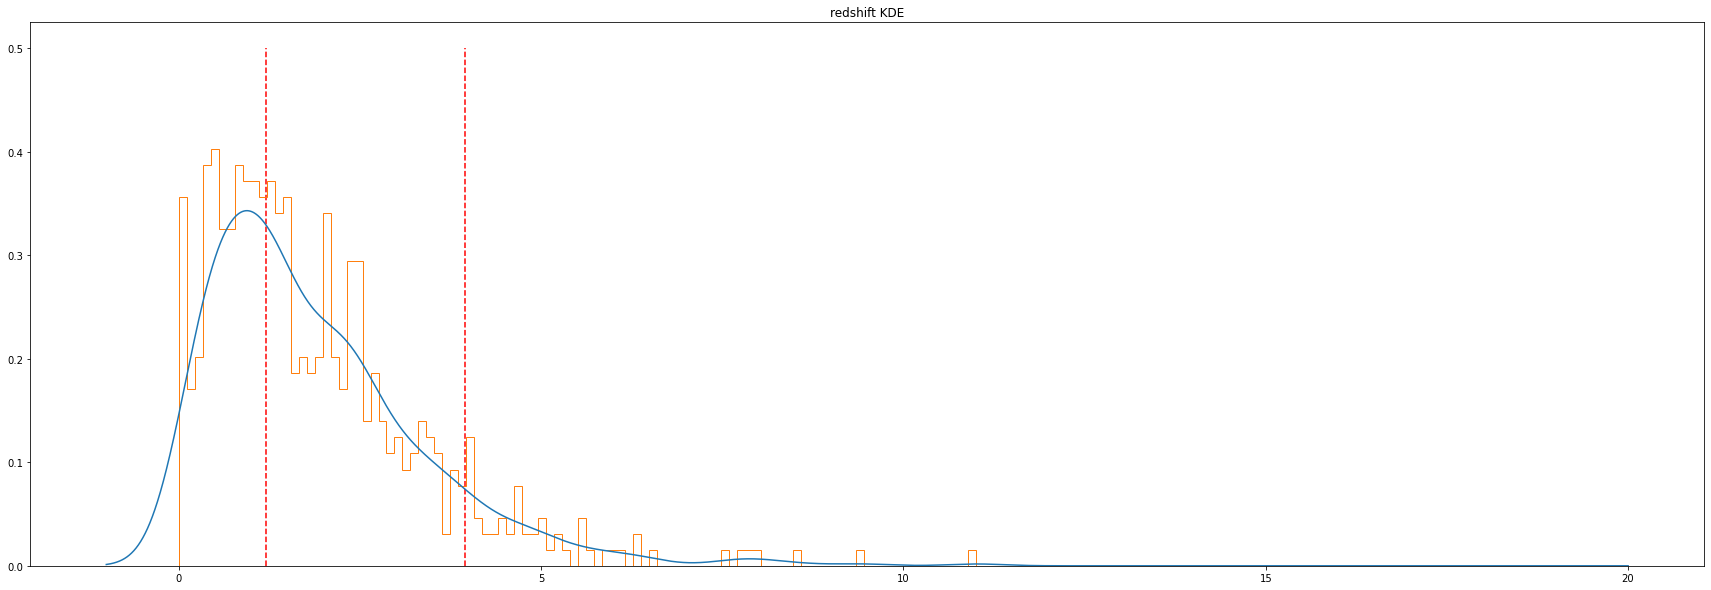

In [11]:
plt.figure(figsize=(30,10))
plt.vlines(centers[0],0,0.5,color='red',linestyle='--')
plt.vlines(centers[1],0,0.5,color='red',linestyle='--')
plt.plot(xgrid,pdf)
plt.hist(z,bins=100,density=True, histtype='step')
plt.title('redshift KDE')

Let me take a parametric approch with a GMM. Plotting the means of the two gaussian component i obtain more or less the same result of before.

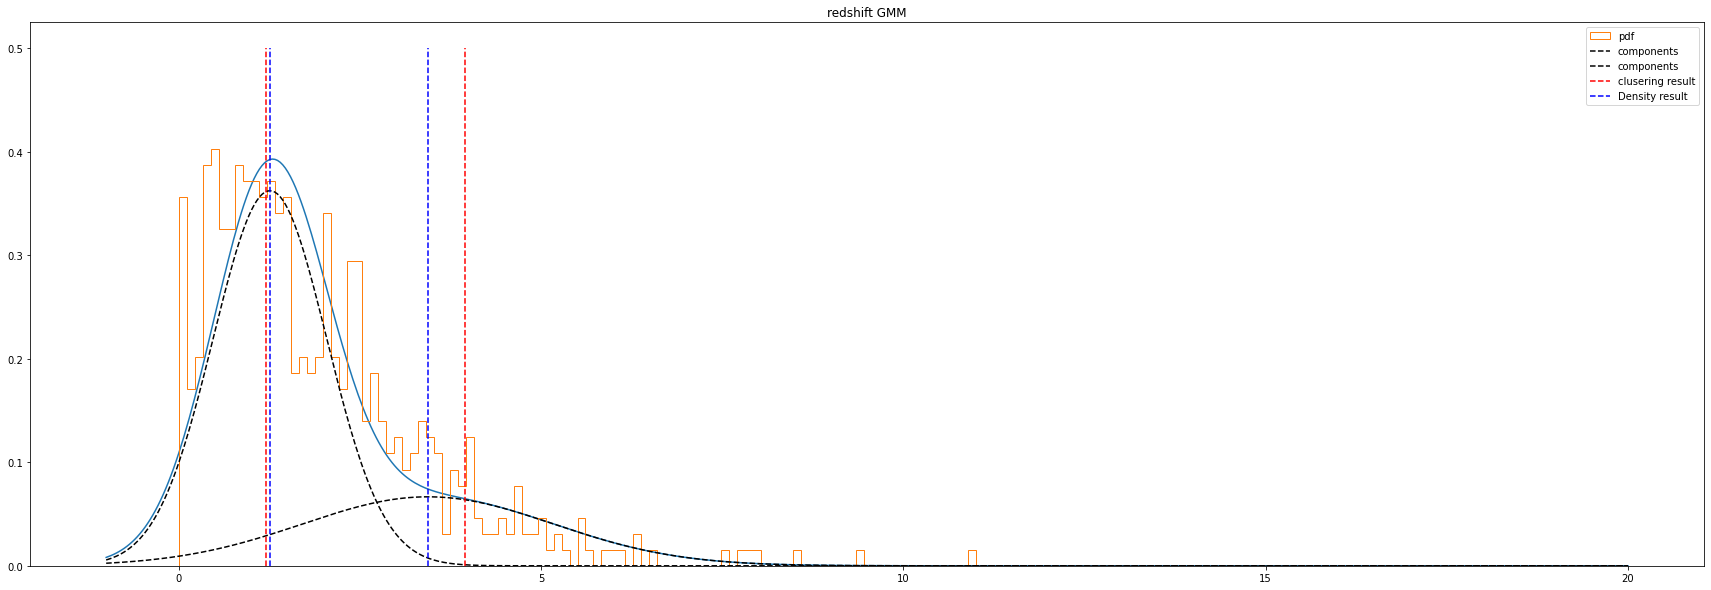

In [8]:
xgrid=np.linspace(-1,20,587)
gmm = GaussianMixture(2)
gmm.fit(X)
log_pdf = gmm.score_samples(xgrid[:,None])
responsabilities=gmm.predict_proba(xgrid[:,None])
pdf_gmm=np.exp(log_pdf)
pdf_individual=responsabilities * pdf_gmm[:,np.newaxis]


centers_gmm = gmm.means_

plt.figure(figsize=(30,10))
plt.plot(xgrid,pdf_gmm)
plt.hist(z,bins=100,density=True, histtype='step', label='pdf')
plt.plot(xgrid, pdf_individual, '--k', label='components')
plt.vlines(centers[0],0,0.5,color='red',linestyle='--', label='clusering result')
plt.vlines(centers[1],0,0.5,color='red',linestyle='--')
plt.vlines(centers_gmm[0],0,0.5,color='blue',linestyle='--', label='Density result')
plt.vlines(centers_gmm[1],0,0.5,color='blue',linestyle='--')

plt.title('redshift GMM')
plt.legend(loc=0)





Text(10, 0.3, 'Long GRB')

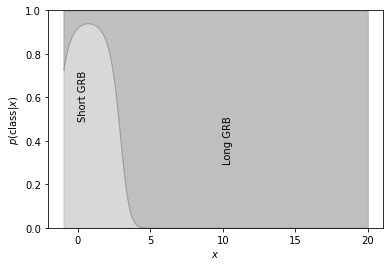

In [13]:
# plot the posterior pdf to check the treshold

p = responsabilities
#p = p[:, (1, 0, 2)]  # rearrange order so the plot looks better
p = p.cumsum(1).T

plt.fill_between(xgrid, 0, p[0], color='gray', alpha=0.3)
plt.fill_between(xgrid, p[0], p[1], color='gray', alpha=0.5)
plt.ylim(0,1)
plt.xlabel('$x$')
plt.ylabel(r'$p({\rm class}|x)$')

plt.text(0, 0.5, 'Short GRB', rotation='vertical')
plt.text(10, 0.3, 'Long GRB', rotation='vertical')



Let me fix a threshold by hand ad then try to understand which is the better value in this case.

False positive 0.0433397793946757
False negative 0.076236654640461
Completness 0.923763345359539
Contamination 0.2968881664234171


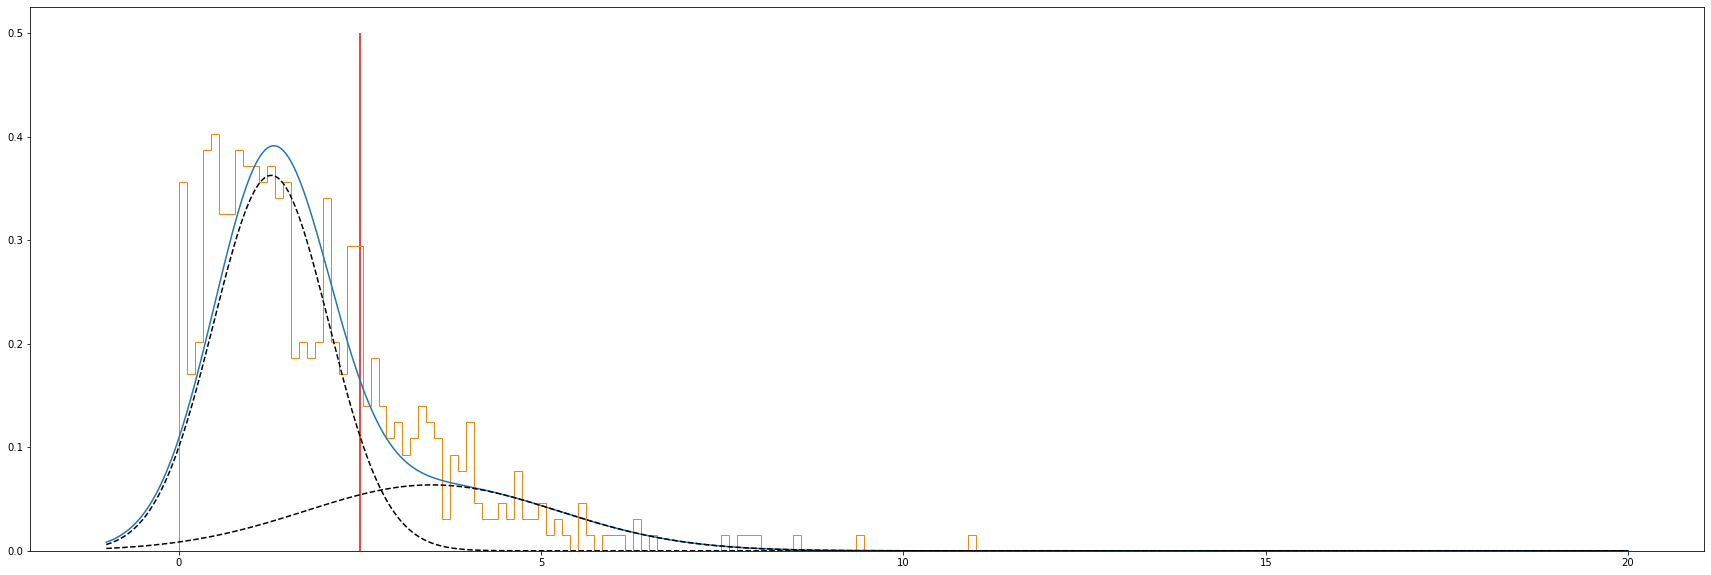

In [14]:
plt.figure(figsize=(30,10))
plt.plot(xgrid,pdf_gmm)
plt.hist(z,bins=100,density=True, histtype='step', label='pdf')
plt.plot(xgrid, pdf_individual, '--k', label='components')
plt.vlines(2.5,0,0.5,color='red', label='threshold')

xc=2.5
a=0.1
fp=np.trapz(pdf_individual[:,0][xgrid>xc],dx=xgrid[1]-xgrid[0])
fn=np.trapz(pdf_individual[:,1][xgrid<xc],dx=xgrid[1]-xgrid[0])
completness=1-fn
contamination=(1-a)*fp / ((completness*a)+(1-a)*fp)

print('False positive', fp)
print('False negative', fn)
print('Completness', completness)
print('Contamination',contamination)

Assuming GMM return the true individual pdf, let me try to compare the classification parameters. Basically I compare efficeny and completeness as function od the treshold, and I higlight the value where the precision is 90%

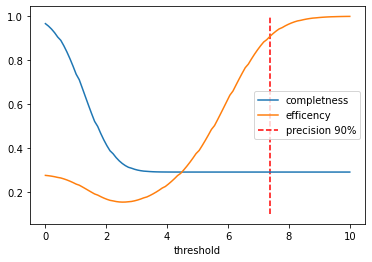

In [54]:
a=0.1# since long GRB are more likely to be observed
completness=[]
contamination=[]

ranges=np.linspace(0,10,100)

for xc in ranges:
    fp=np.trapz(pdf_individual[:,0][xgrid>=xc],dx=xgrid[1]-xgrid[0])
    fn=np.trapz(pdf_individual[:,1][xgrid<xc],dx=xgrid[1]-xgrid[0])
    C=1-fn
    completness.append(C)
    contamination.append(1-((1-a)*fp) / ((C*a)+(1-a)*fp))
    

comp_90_eff = np.where(np.array(contamination)>=0.9,ranges,1000)
perc90 = np.min(comp_90_eff)

plt.vlines(perc90,0.1,1,color='red',linestyle='--', label='precision 90%')
plt.plot(ranges,completness, label='completness')
plt.plot(ranges,contamination, label='efficency')
plt.xlabel('threshold')
plt.legend(loc=0)

Does exist some slection bias?

I use rejection sampling to detect some selction bias

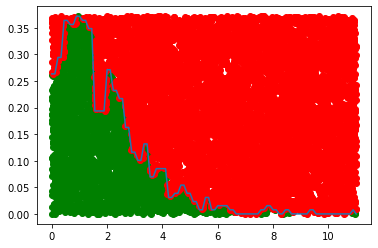

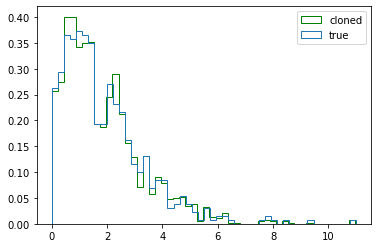

In [55]:
counts, bins = np.histogram(z, bins=50, density=True)
ymax = counts.max() # find the maximum

f=rv_histogram((counts,bins))

N=10000

xg = np.linspace(np.min(z),np.max(z),100)

plt.plot(xg,f.pdf(xg))


x = np.random.uniform(np.min(z),np.max(z),N) # proposal distribution
y = np.random.uniform(0,ymax,N) # samples


plt.scatter(x[y<f.pdf(x)],y[y<f.pdf(x)],c='green')
plt.scatter(x[y>f.pdf(x)],y[y>f.pdf(x)],c='red') # rejected samples

plt.show()
goodpoints = x[y<f.pdf(x)]


plt.hist(goodpoints,bins=50,density=True,histtype='step',color='green', label='cloned')
plt.hist(z,bins=50,density=True, histtype='step', label='true')
plt.legend(loc=0)

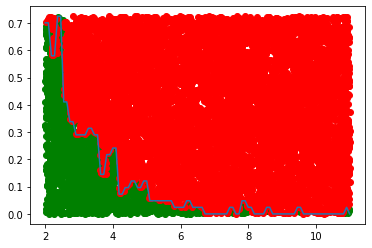

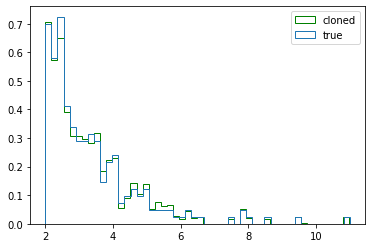

In [10]:

z=z[z>=2]
counts, bins = np.histogram(z, bins=50, density=True)
ymax = counts.max() # find the maximum

f=rv_histogram((counts,bins))

N=10000

xg = np.linspace(np.min(z),np.max(z),100)

plt.plot(xg,f.pdf(xg))


x = np.random.uniform(np.min(z),np.max(z),N) # proposal distribution
y = np.random.uniform(0,ymax,N) # samples


plt.scatter(x[y<f.pdf(x)],y[y<f.pdf(x)],c='green')
plt.scatter(x[y>f.pdf(x)],y[y>f.pdf(x)],c='red') # rejected samples

plt.show()
goodpoints = x[y<f.pdf(x)]


plt.hist(goodpoints,bins=50,density=True,histtype='step',color='green', label='cloned')
plt.hist(z,bins=50,density=True, histtype='step', label='true')
plt.legend(loc=0)



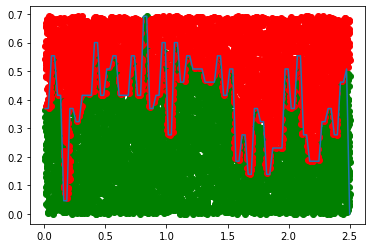

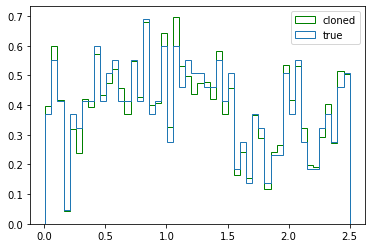

In [14]:
z=z[z<2.5]
counts, bins = np.histogram(z, bins=50, density=True)
ymax = counts.max() # find the maximum

f=rv_histogram((counts,bins))

N=10000

xg = np.linspace(np.min(z),np.max(z),100)

plt.plot(xg,f.pdf(xg))


x = np.random.uniform(np.min(z),np.max(z),N) # proposal distribution
y = np.random.uniform(0,ymax,N) # samples


plt.scatter(x[y<f.pdf(x)],y[y<f.pdf(x)],c='green')
plt.scatter(x[y>f.pdf(x)],y[y>f.pdf(x)],c='red') # rejected samples

plt.show()
goodpoints = x[y<f.pdf(x)]


plt.hist(goodpoints,bins=50,density=True,histtype='step',color='green', label='cloned')
plt.hist(z,bins=50,density=True, histtype='step', label='true')
plt.legend(loc=0)

Let me retry clustering after a PCA reduction

In [15]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

print(names)

['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']


In [16]:
GRB_name=np.array(data[0],dtype=str)
GRB_name_fermi=np.array(data[1],dtype=str)
T0=np.array(data[2],dtype=str)
#t_trigger=np.array(data[3],dtype=float)
ra=np.array(data[3],dtype=float)
dec=np.array(data[4],dtype=float)
pos_err=np.array(data[5],dtype=float)
T90=np.array(data[6],dtype=float)
T_90_err=np.array(data[7],dtype=float)
T_90_start=np.array(data[8],dtype=str)
fluence=np.array(data[9],dtype=float)
fluence_error=np.array(data[10],dtype=float)
redshift=np.array(data[11],dtype=float)
T100=np.array(data[12],dtype=float)
GBM_locaed=np.array(data[13],dtype=str)
mjd=np.array(data[14],dtype=float)
#variable_source=np.array(data[15],dtype=float)

587 587 587 587 587 587


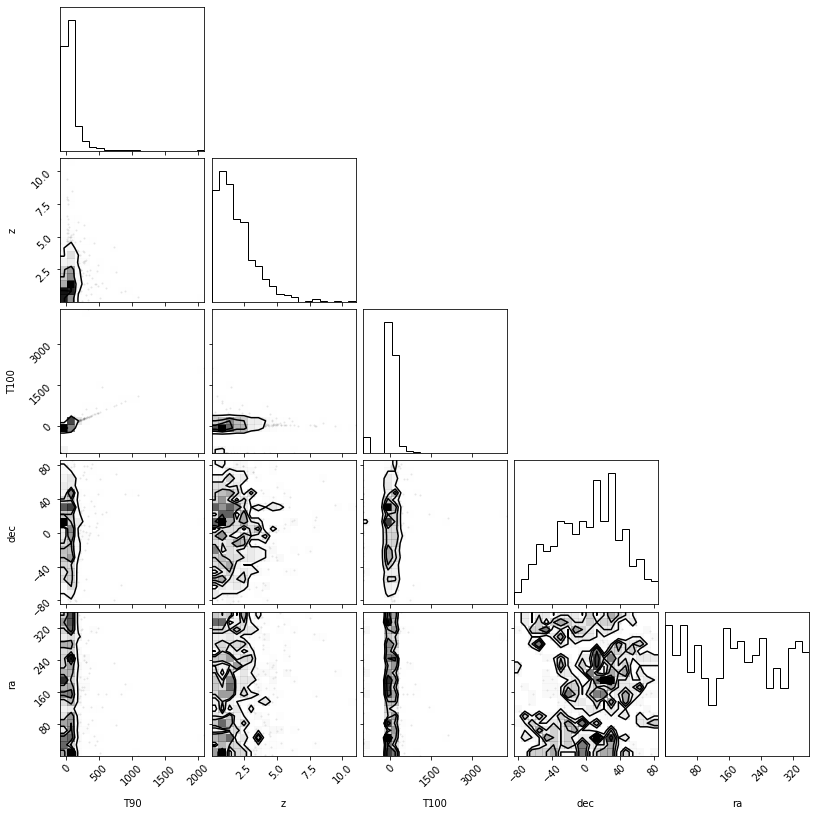

In [17]:
#X_pca=np.where(X_pca==-999,0,X_pca)
#X_pca = xx[~np.isnan(xx)]
#X_pca = X_pca.reshape(-1,5)
#X_pca.shape
zz=redshift[redshift>=0]
rara=ra[redshift>=0]
decdec=dec[redshift>=0]
T100100=T100[redshift>=0]
T90_pos = T90[redshift>=0]
T9090 = np.where(T90_pos<=0,np.mean(T90),T90_pos)

print(len(T90_pos),len(T9090),len(zz), len(T100100),len(decdec),len(rara))

fig=corner.corner(np.array([T9090,zz,T100100,decdec,rara]).T, labels=['T90','z','T100','dec','ra'])

[0]
128.68859182089506
number of estimated clusters : 1


<ipython-input-18-99a76012aff6>:61: UserWarning: No contour levels were found within the data range.
  plt.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],


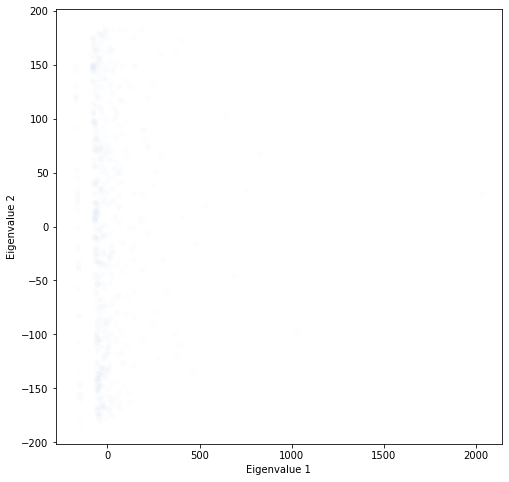

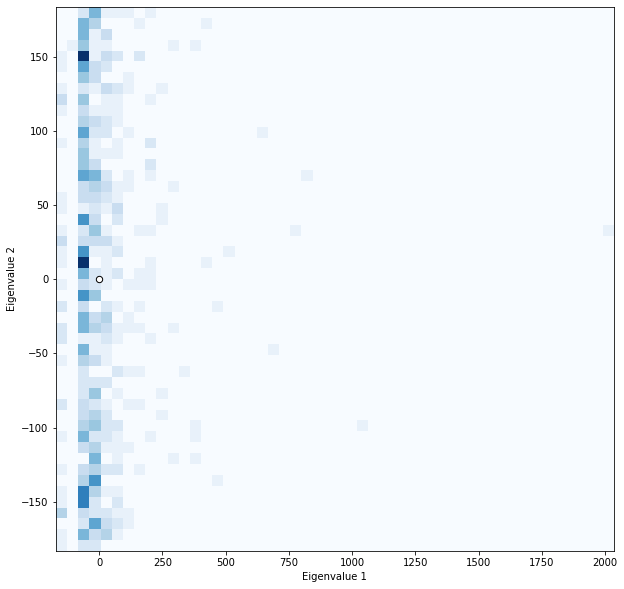

In [18]:
# 1.2 Mean Shift clustering

X=np.array([T9090,zz,decdec,rara]).T

pca = PCA(n_components=2) # 2 components
pca.fit(X) # Do the fitting

X_reduced = pca.transform(X)

plt.figure(figsize=(8,8))
plt.scatter(X_reduced[:,0], X_reduced[:,1], marker="o", color='C0', alpha=0.01, edgecolors='None')
plt.xlabel('Eigenvalue 1')
plt.ylabel('Eigenvalue 2')


scaler = preprocessing.StandardScaler()
#bandwidth = 1.5
bandwidth = estimate_bandwidth(X_reduced) # this takes a long time...beware
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False)
ms.fit(scaler.fit_transform(X_reduced))

labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])
print(labels_unique)
print(bandwidth)
print("number of estimated clusters :", n_clusters)

# Make some plots
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X_reduced[:,0], X_reduced[:,1], 50)

# plot density
plt.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(ms.cluster_centers_)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    plt.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('Eigenvalue 1')
ax.set_ylabel('Eigenvalue 2')

plt.show()


/Users/federicoastori/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/federicoastori/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


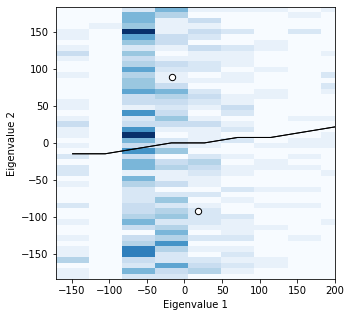

In [19]:


clf = KMeans(n_clusters=2) #Try 2 clusters to start with
clf.fit(X)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(X) #labels for each of the points

# Compute the KMeans clustering
n_clusters = 2
scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters)
clf.fit(scaler.fit_transform(X_reduced))

# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X_reduced[:,0], X_reduced[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')

    H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0],200)
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('Eigenvalue 1')
ax.set_ylabel('Eigenvalue 2')

plt.show()


In [20]:
len(gmmoutcome)

NameError: name 'gmmoutcome' is not defined

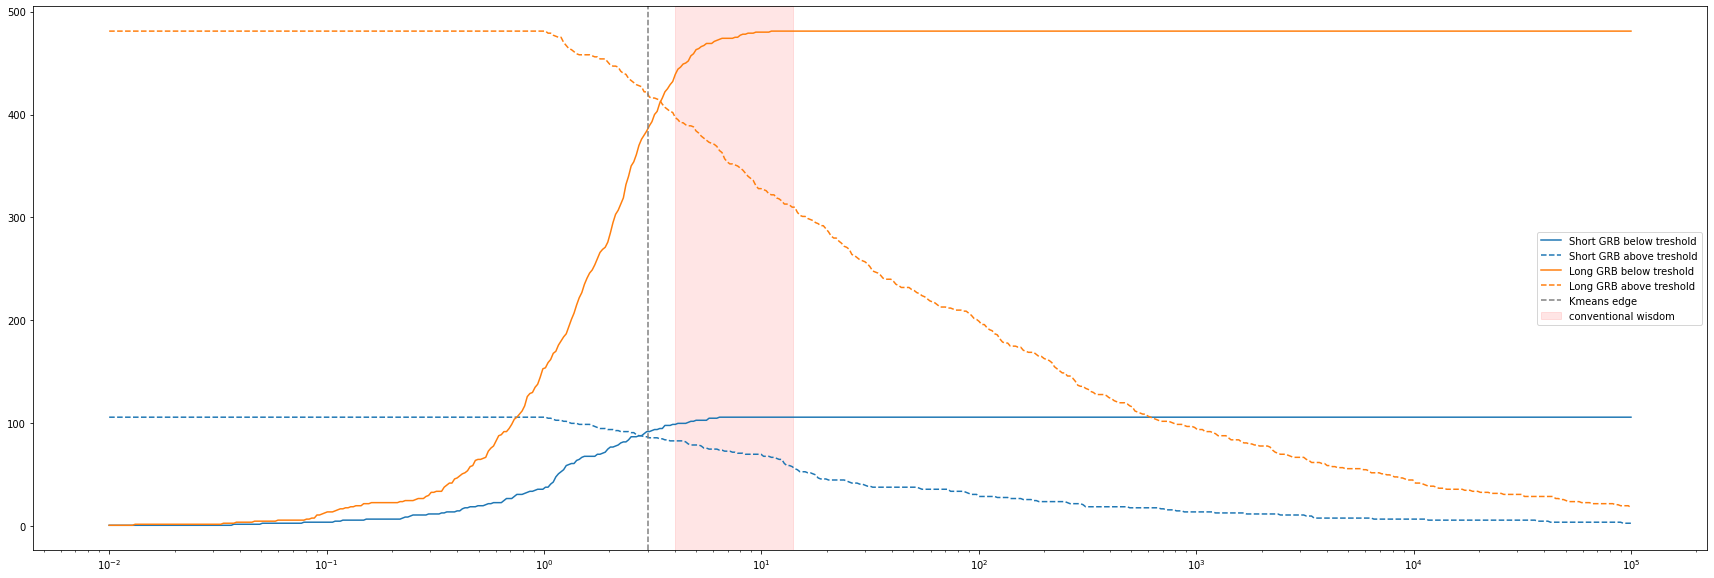

In [23]:
gmmoutcome = np.array(responsabilities[:,0]<responsabilities[:,1],dtype='int')
xgrid=np.logspace(-2,5,587)

shortbelow = np.array( [ np.sum( gmmoutcome[zz<thr]==0)  for thr in (xgrid)] )
longbelow = np.array( [ np.sum( gmmoutcome[zz<thr]==1)  for thr in (xgrid)] )

shortabove = np.array( [ np.sum( gmmoutcome[zz>thr]==0)  for thr in np.log10(xgrid)] )
longabove = np.array( [ np.sum( gmmoutcome[zz>thr]==1)  for thr in np.log10(xgrid)] )

plt.figure(figsize=(30,10))
plt.plot(xgrid,shortbelow,label='Short GRB below treshold', c='C0',ls='solid')
plt.plot(xgrid,shortabove,label='Short GRB above treshold',c='C0',ls='dashed')
plt.plot(xgrid,longbelow,label='Long GRB below treshold',c='C1',ls='solid')
plt.plot(xgrid,longabove,label='Long GRB above treshold',c='C1',ls='dashed')
plt.semilogx()
plt.axvline(3,c='gray',ls='dashed',label='Kmeans edge') # threshold by hand

plt.axvspan(4,14,alpha=0.1,color='red',label='conventional wisdom') # short GRB max_redshift=4 and long =14

plt.legend()

# Let me repeaat the analysis with T90 to check if I obtain the same result

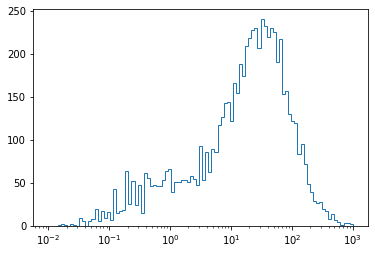

In [24]:
plt.hist(T90[T90>=0],bins= np.logspace(-2,3,100), histtype='step')
plt.xscale('log')

In [25]:
# I want T90 in log scale

log_T90 = np.log10(T90)
log_T90=log_T90[~np.isnan(log_T90)][:,None]
X=log_T90

<ipython-input-25-775890f8d782>:3: RuntimeWarning: invalid value encountered in log10
  log_T90 = np.log10(T90)


In [26]:

clf = KMeans(n_clusters=2) #Try 2 clusters to start with
clf.fit(X)

centroid = clf.cluster_centers_
centers=centroid.squeeze()
print(centers)

#let me try another algorithm
bandwidth = sklearn.cluster.estimate_bandwidth(X)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False) 
ms.fit(X)

centroid_ms = clf.cluster_centers_
centers_ms =centroid_ms.squeeze()
print(centers_ms)


/Users/federicoastori/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[ 1.52696211 -0.04156313]
[ 1.52696211 -0.04156313]


In [27]:
labels = clf.predict(X)
edge = ( np.mean( [max(X[labels==0]), min(X[labels==1]) ]))

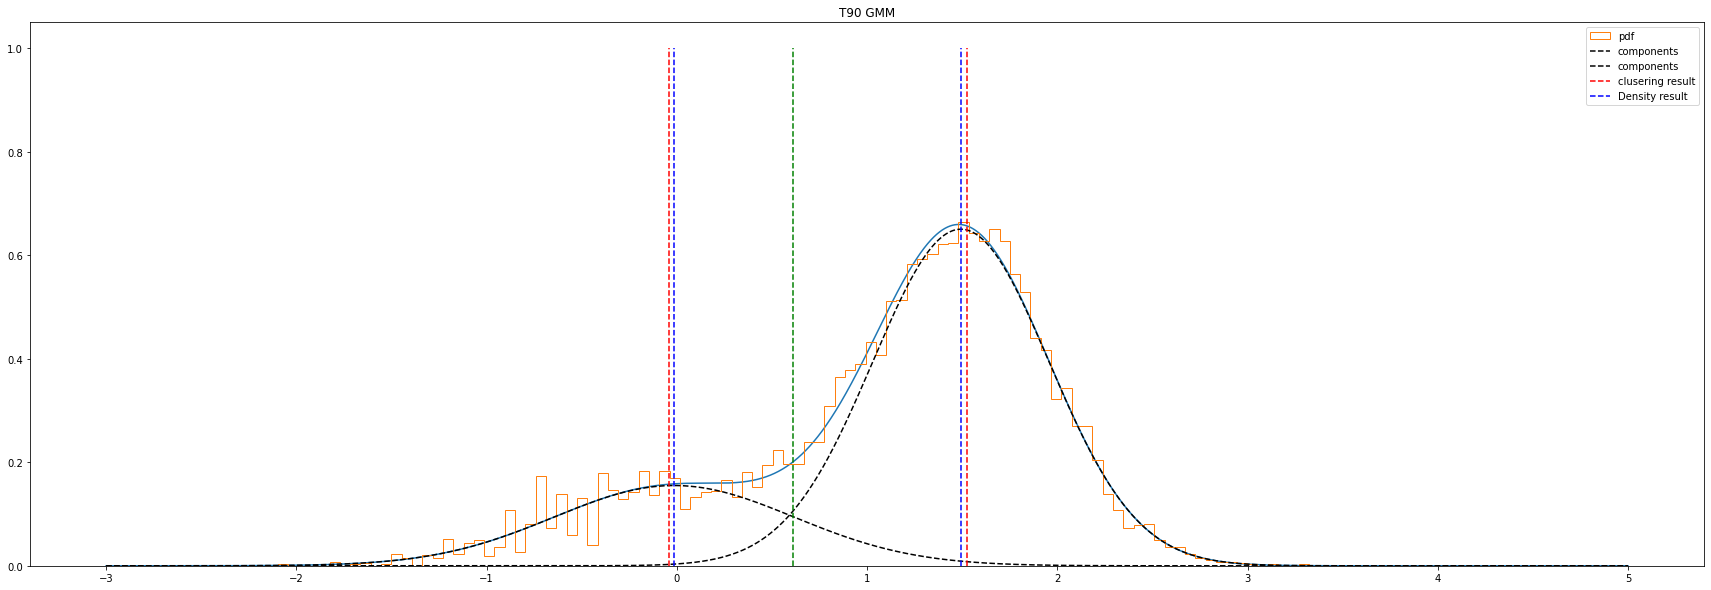

In [28]:
xgrid=np.linspace(-3,5,7038)
gmm = GaussianMixture(2)
gmm.fit(X)
log_pdf = gmm.score_samples(xgrid[:,None])
responsabilities=gmm.predict_proba(xgrid[:,None])
pdf_gmm=np.exp(log_pdf)
pdf_individual=responsabilities * pdf_gmm[:,np.newaxis]


centers_gmm = gmm.means_

plt.figure(figsize=(30,10))
plt.plot(xgrid,pdf_gmm)
plt.hist(log_T90,bins=100,density=True, histtype='step', label='pdf')
plt.plot(xgrid, pdf_individual, '--k', label='components')
plt.vlines(centers[0],0,1,color='red',linestyle='--', label='clusering result')
plt.vlines(centers[1],0,1,color='red',linestyle='--')
plt.vlines(centers_gmm[0],0,1,color='blue',linestyle='--', label='Density result')
plt.vlines(centers_gmm[1],0,1,color='blue',linestyle='--')
plt.vlines(edge,0,1,color='green',linestyle='--')

plt.title('T90 GMM')
plt.legend(loc=0)

In [29]:
gmmoutcome = np.array(responsabilities[:,0]<responsabilities[:,1],dtype='int')
C=confusion_matrix(gmmoutcome,labels)
C

array([[2807, 1071],
       [2419,  741]])

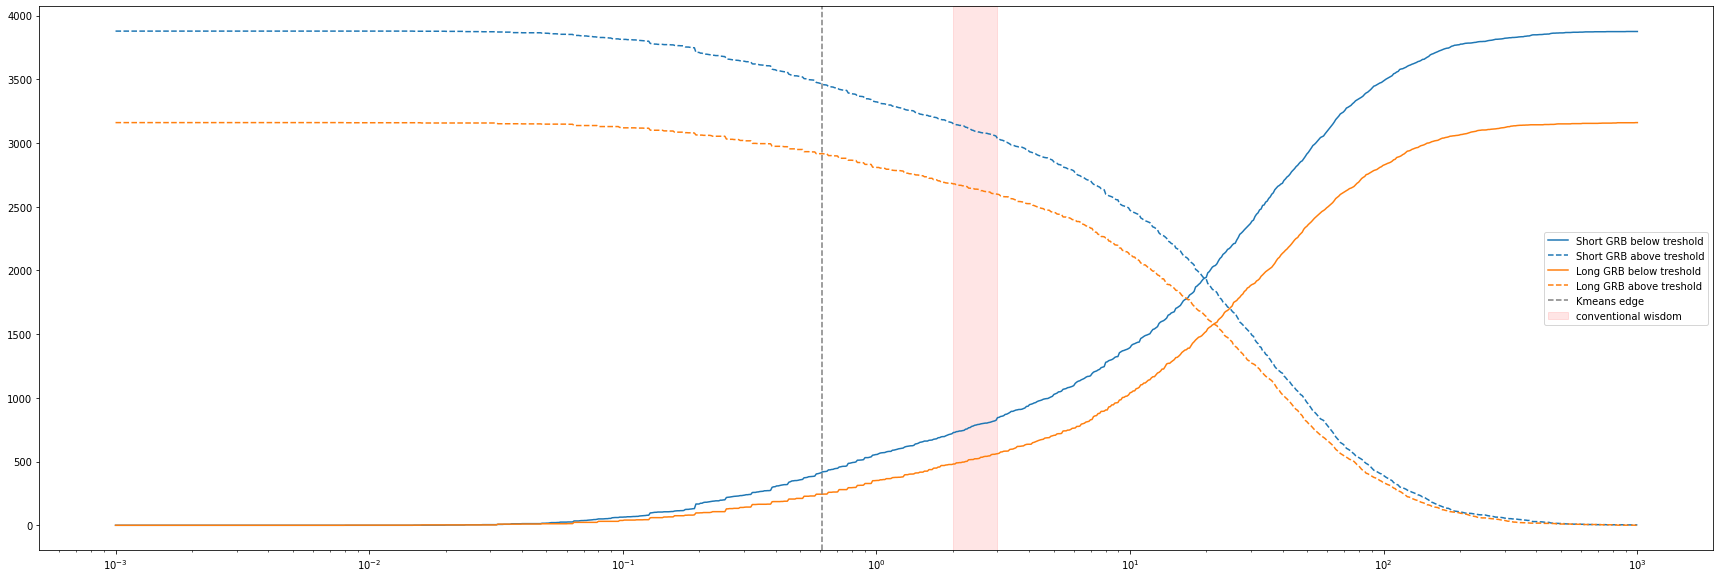

In [34]:

log_T90 = log_T90[~np.isnan(log_T90)]
xgrid=np.logspace(-3,3,1000)

shortbelow = np.array( [ np.sum( gmmoutcome[log_T90<thr]==0)  for thr in np.log10(xgrid)] )
longbelow = np.array( [ np.sum( gmmoutcome[log_T90<thr]==1)  for thr in np.log10(xgrid)] )

shortabove = np.array( [ np.sum( gmmoutcome[log_T90>thr]==0)  for thr in np.log10(xgrid)] )
longabove = np.array( [ np.sum( gmmoutcome[log_T90>thr]==1)  for thr in np.log10(xgrid)] )

plt.figure(figsize=(30,10))
plt.plot(xgrid,shortbelow,label='Short GRB below treshold', c='C0',ls='solid')
plt.plot(xgrid,shortabove,label='Short GRB above treshold',c='C0',ls='dashed')
plt.plot(xgrid,longbelow,label='Long GRB below treshold',c='C1',ls='solid')
plt.plot(xgrid,longabove,label='Long GRB above treshold',c='C1',ls='dashed')
plt.semilogx()
plt.axvline(edge,c='gray',ls='dashed',label='Kmeans edge')

plt.axvspan(2,3,alpha=0.1,color='red',label='conventional wisdom')

plt.legend()